In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from src.common.analysis_and_plots import Visualize as V
from src.features.build_features import FeatureEngineering as FE
from src.common.globals import G
from src.common.globals import split_train_valid_test, get_naive_forecast, calc_errors, save_errors_to_table
from src.data.get_data import CSVsLoader
from src.common.logs import setup_logging, log_model_info

import logging
import os

logger = setup_logging(logger_name=__name__,
                        console_level=logging.INFO, 
                        log_file_level=logging.INFO)

PROJECT_PATH = G.get_project_root()
DATA_DIR_PROCESSED = os.path.join(PROJECT_PATH, r'data\03_processed\daily_full')

config = {
    'AV': {
        'key': '',
        'ticker': 'MSFT',
        'outputsize': 'full',
        'key_adjusted_close': 'Adj Close',
        'key_volume': 'Volume',
    },
    'data': {
        'test_size': 0.05,
    }, 
    'model': {
        'name': 'LSTM', 
        'window': 20,
        'batch_size' : 30,
        'shuffle_buffer_size' : 1000,
        'epochs' : 100,
        'optimizer': tf.keras.optimizers.Adam(),
        'loss': tf.keras.losses.Huber(),
    },
}


In [2]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
        """Generates dataset windows

        Args:
        series (array of float) - contains the values of the time series
        window_size (int) - the number of time steps to include in the feature
        batch_size (int) - the batch size
        shuffle_buffer(int) - buffer size to use for the shuffle method

        Returns:
        dataset (TF Dataset) - TF Dataset containing time windows
        """

        # Generate a TF Dataset from the series values
        dataset = tf.data.Dataset.from_tensor_slices(series)

        # Window the data but only take those with the specified size
        dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

        # Flatten the windows by putting its elements in a single batch
        dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

        # Create tuples with features and labels
        dataset = dataset.map(lambda window: (window[:-1], window[-1]))

        # Shuffle the windows
        dataset = dataset.shuffle(shuffle_buffer)

        # Create batches of windows
        dataset = dataset.batch(batch_size).prefetch(1)

        return dataset

In [3]:
df = CSVsLoader(ticker=config['AV']['ticker'], directory=DATA_DIR_PROCESSED)

test_size_int = int(len(df) * config['data']['test_size'])
df_train = df.iloc[:-test_size_int]
df_test = df.iloc[-test_size_int:]

# DeNormalize the training data in the last layer of the model
max_value = df_train['Adj Close'].max()

train_dataset = windowed_dataset(df_train['Adj Close'], 
                                window_size=config['model']['window'], 
                                batch_size=config['model']['batch_size'], 
                                shuffle_buffer=config['model']['shuffle_buffer_size'])


2023-09-18 16:24:46 - src.data.get_data - INFO - Loaded "..\P7-Trading-Bot\data\03_processed\daily_full\MSFT-daily-full.csv". Number data points 5995. From "1999-11-01 00:00:00" to "2023-08-29 00:00:00"


In [16]:
# Build the Model
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                                strides=1,
                                activation="relu",
                                padding='causal',
                                input_shape=[config['model']['window'], 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * max_value) # Unnormalize because of tanh activation in LSTM, whicn outputs values [-1, 1]
        ],
        name=config['model']['name'])

model._name = f'{model._name}_{str(model.count_params())}'

In [17]:
log_model_info(config, model, logger)

2023-09-18 16:26:56 - __main__ - INFO - ==============================================================================================
2023-09-18 16:26:56 - __main__ - INFO - =================================== MODEL CONFIF AND SETUP ===================================
2023-09-18 16:26:56 - __main__ - INFO - ==============================================================================================
2023-09-18 16:26:56 - __main__ - INFO - AV_key: , AV_ticker: MSFT, AV_outputsize: full, AV_key_adjusted_close: Adj Close, AV_key_volume: Volume, 
2023-09-18 16:26:56 - __main__ - INFO - data_test_size: 0.05, 
2023-09-18 16:26:56 - __main__ - INFO - ----------------------------------------------------------------------
2023-09-18 16:26:56 - __main__ - INFO - model_name: LSTM
2023-09-18 16:26:56 - __main__ - INFO - model_window: 20
2023-09-18 16:26:56 - __main__ - INFO - model_batch_size: 30
2023-09-18 16:26:56 - __main__ - INFO - model_shuffle_buffer_size: 1000
2023-09-18 16:26:56 - __main

#### ADAM optimizer - Vasyl try

In [6]:
# Set the training parameters
optimizer = tf.keras.optimizers.Adam() 
model.compile(loss=tf.keras.losses.Huber(), 
                optimizer=optimizer, 
                metrics=["mae"],
                )    

# Train the model
history = model.fit(train_dataset, epochs=config['model']['epochs'])

# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

Epoch 1/100
190/190 [==============================] - 7s 17ms/step - loss: 6.0171 - mae: 6.4776
Epoch 2/100
190/190 [==============================] - 2s 12ms/step - loss: 4.4844 - mae: 4.9329
Epoch 3/100
190/190 [==============================] - 2s 12ms/step - loss: 5.1628 - mae: 5.5703
Epoch 4/100
190/190 [==============================] - 2s 13ms/step - loss: 4.4478 - mae: 4.8612
Epoch 5/100
190/190 [==============================] - 2s 12ms/step - loss: 4.2953 - mae: 4.7135
Epoch 6/100
190/190 [==============================] - 2s 12ms/step - loss: 2.8139 - mae: 3.1991
Epoch 7/100
190/190 [==============================] - 2s 13ms/step - loss: 3.2052 - mae: 3.6205
Epoch 8/100
190/190 [==============================] - 2s 13ms/step - loss: 2.9788 - mae: 3.3647
Epoch 9/100
190/190 [==============================] - 2s 12ms/step - loss: 2.8499 - mae: 3.1967
Epoch 10/100
190/190 [==============================] - 2s 12ms/step - loss: 2.8553 - mae: 3.2652
Epoch 11/100
190/190 [=======

2023-09-18 15:42:53 - src.common.analysis_and_plots - INFO - Plot "LSTM-MAE and Loss-2023-09-18_15-42-53-2.png" saved to "D:\Study 2018 and later\Mignimind Bootcamp\Code\P7-Trading-Bot\figures\LSTM-MAE and Loss-2023-09-18_15-42-53-2.png"


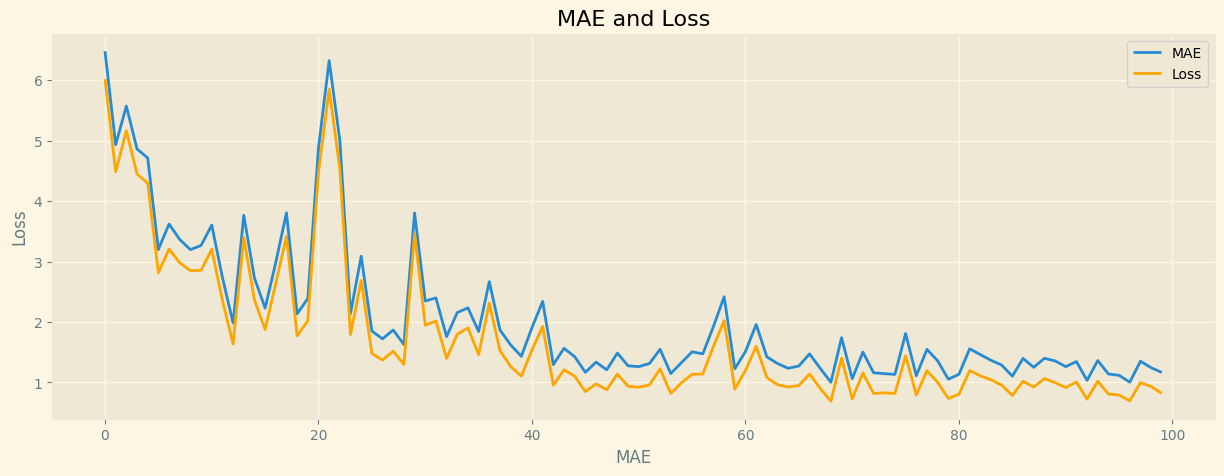

In [7]:
# Plot MAE and Loss
zoom = int(len(mae) * 1)
V.plot_series(x=range(config['model']['epochs'])[-zoom:],
                y=(mae[-zoom:],loss[-zoom:]),
                model_name=config['model']['name'],
                title='MAE and Loss',
                xlabel='MAE',
                ylabel='Loss',
                legend=['MAE', 'Loss']
            )

In [8]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

10/10 [==============================] - 1s 7ms/step


2023-09-18 15:42:54 - src.common.analysis_and_plots - INFO - Plot "LSTM-None-2023-09-18_15-42-54-3.png" saved to "D:\Study 2018 and later\Mignimind Bootcamp\Code\P7-Trading-Bot\figures\LSTM-None-2023-09-18_15-42-54-3.png"


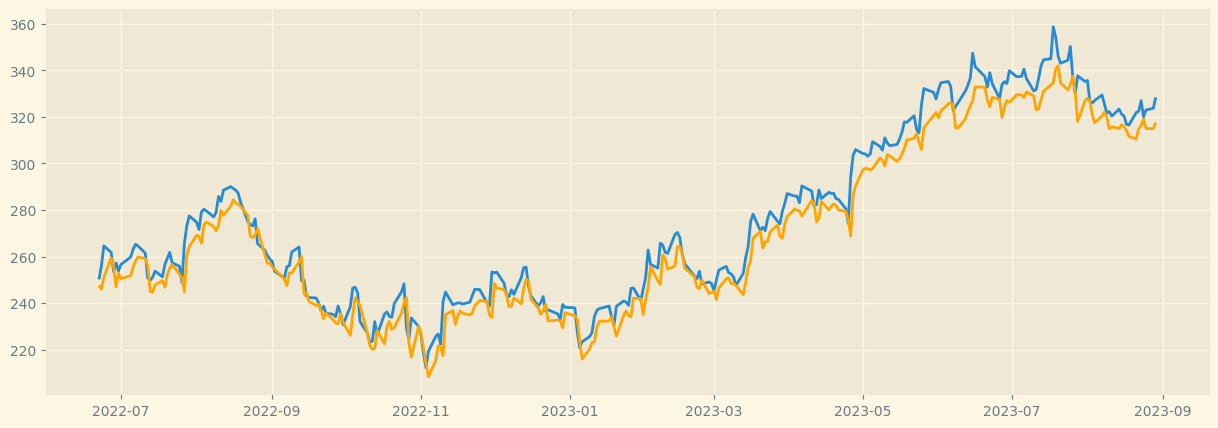

In [9]:
# Reduce the original series
forecast_series = df['Adj Close'].iloc[-test_size_int - config['model']['window']:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, config['model']['window'], config['model']['batch_size'])

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
V.plot_series(x=df_test.index, 
              y=(df_test['Adj Close'], results),
              model_name=config['model']['name'])

In [10]:
# Calculate errors
naive_forecast = get_naive_forecast(df).iloc[-len(df_test['Adj Close']):]
rmse, mae, mape, mase = calc_errors(df_test['Adj Close'], results, naive_forecast)
save_errors_to_table(config['model']['name'], {'rmse': rmse, 'mae': mae, 'mape': mape, 'mase': mase})

2023-09-18 15:42:54 - src.common.globals - INFO - Test RMSE: $ 8.229
2023-09-18 15:42:54 - src.common.globals - INFO - Test MAE : $ 6.691
2023-09-18 15:42:54 - src.common.globals - INFO - Test MAPE:   0.024
2023-09-18 15:42:54 - src.common.globals - INFO - Test MASE:   1.65
2023-09-18 15:42:54 - src.common.globals - INFO - Errors saved to for LSTM model to "logs/models_table.csv" file.
